# Ejercicio Aprendizaje No Supervisado

##0. Cargamos el dataset


In [ ]:
# Montamos la unidad Drive para acceder a los archivos de Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Especificamos la ruta hasta la carpeta donde tenemos csv
%ls /content/drive/MyDrive/Colab_Notebooks/Machine_Learning/Entrega_1/Mall_Customers.csv

ls: cannot access '/content/drive/MyDrive/Colab_Notebooks/Machine_Learning/Entrega_1/Mall_Customers.csv': No such file or directory


In [ ]:
# Importamos las librerías necesarias
import pandas as pd
import numpy as np

# Cargamos el archivo csv en un DataFrame
df = pd.read_csv(
    "/content/drive/MyDrive/Colab_Notebooks/MACHINE_LEARNING/ENTREGA_1/Mall_Customers.csv", encoding='utf-8', encoding_errors='replace')

##1. Exploración de Datos

In [ ]:
print("Tamaño df:\n", df.shape)

print("Columnas del df:\n", df.columns)

df.info()

df.describe()

Tamaño df:
 (200, 5)
Columnas del df:
 Index(['CustomerID', 'Gender', 'Age', 'Annual Income (k$)',
       'Spending Score (1-100)'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


Primeros pasos del DataFrame: El dataset tiene 200 filas y 5 columnas. No se identifican valores nulos ni outliers evidentes a simple vista. Para confirmarlo, se generarán histogramas. Aunque las columnas son de tipo entero (int), la variable categórica "Genre" deberá convertirse a formato numérico mediante get_dummies para su uso en aprendizaje no supervisado.

df.describe: La edad de los clientes varía entre 18 y 70 años, con una media de 38.85. Los ingresos anuales tienen una amplia dispersión, con un rango de 15 a 137 miles de dólares, mientras que el "Spending Score" está distribuido de manera uniforme, con una media de 50.2. El valor máximo de "Annual Income" (137) si destaca al estar significativamente por encima del tercer cuartil (78), lo que podría indicar outliers en los ingresos.

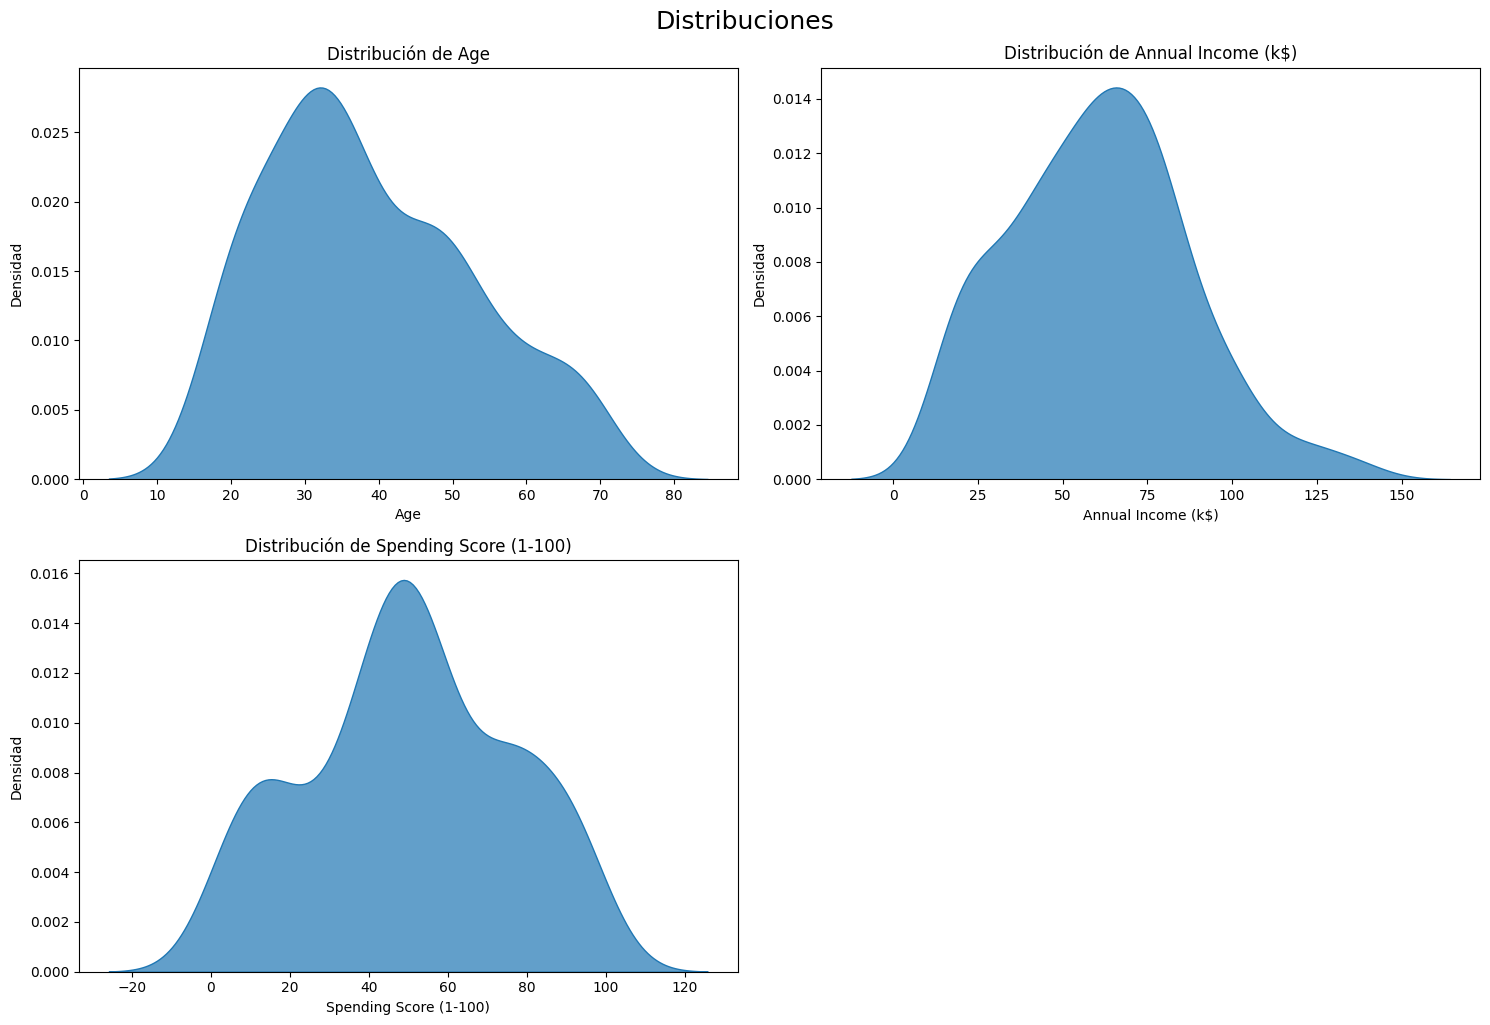

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Seleccionamos las columnas numéricas excluyendo CustomerID
numerical_columns = [col for col in df.select_dtypes(include=['int64']).columns if col != 'CustomerID']

# Configuramos el tamaño de los gráficos
plt.figure(figsize=(15, 10))
rows = len(numerical_columns)
cols = 2

# Creamos los gráficos de densidad
for i, col in enumerate(numerical_columns):
    plt.subplot((len(numerical_columns) + 1) // cols, cols, i + 1)
    sns.kdeplot(data=df[col], fill=True, alpha=0.7)
    plt.title(f'Distribución de {col}')
    plt.xlabel(col)
    plt.ylabel('Densidad')

plt.tight_layout()
plt.suptitle('Distribuciones', y=1.02, fontsize=18)
plt.show()


**Justificación de eliminar "Customer ID":** La variable "Customer ID" es únicamente un identificador único para cada cliente y no aporta información útil para el análisis, por lo tanto, debe ser eliminada para evitar que afecte en los cálculos de clustering.

**Análisis descriptivo de los gráficos:**

* **Age:** La distribución tiene una cola hacia la derecha, lo que indica que hay menos personas a medida que aumenta la edad. La mayor densidad se encuentra en los grupos de edad más jóvenes, aunque también se observa una notable cantidad de personas en edades avanzadas.

* **Annual Income:** Esta variable muestra una distribución cercana a una normal, con la mayor densidad acumulada en el centro de la distribución. Sin embargo, tiene una ligera asimetría negativa, evidenciada por una cola hacia la izquierda, lo cual nos informa que existen algunos clientes con ingresos más bajos.

* **Spending Score:** No sigue una distribución normal. En cambio, se observan varios máximos locales, lo que indica que los niveles de gasto se distribuyen en diferentes segmentos de clientes.

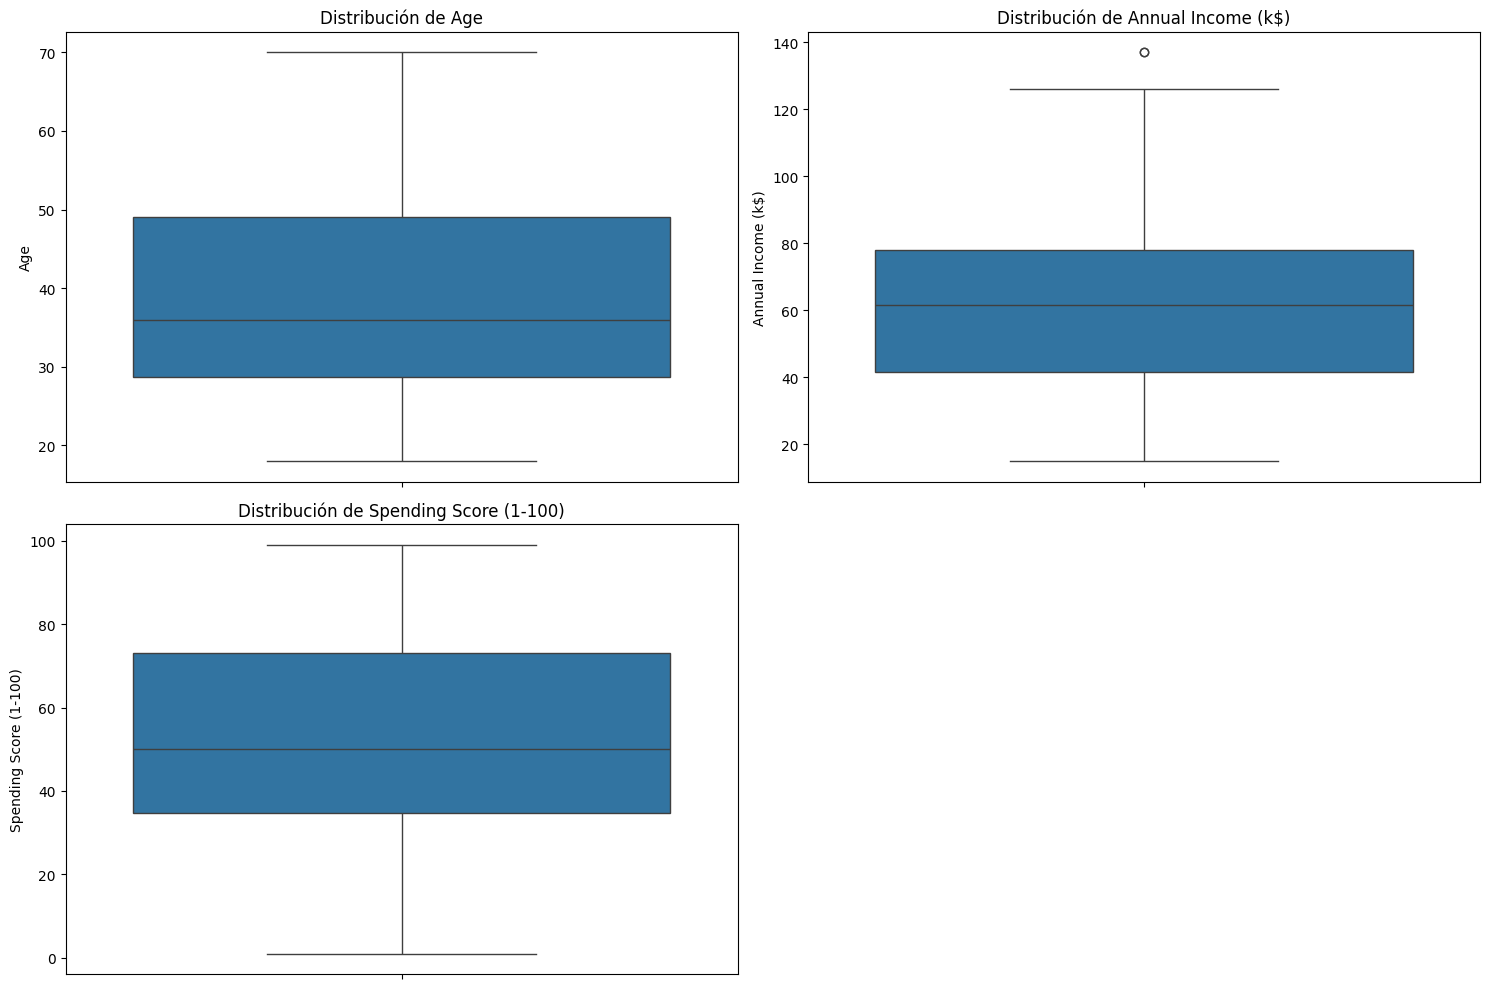

In [ ]:
# Seleccionamos columnas numéricas, excluyendo 'CustomerID'
columns = [col for col in df.select_dtypes(include=['int64']).columns if col != 'CustomerID']

# Creamos un grid con 2 gráficos en la primera fila y 1 en la segunda fila
fig, axes = plt.subplots(2, 2, figsize=(15, 10))  # 2x2 grid
axes = axes.flatten()  # Aplanamos para indexar fácilmente

# Creamos los boxplots para ver valores atípicos
for i, column in enumerate(columns):
    sns.boxplot(y=df[column], ax=axes[i])
    axes[i].set_title(f'Distribución de {column}')

# Ocultamos el último subplot si sobra espacio
if len(columns) < len(axes):
    for j in range(len(columns), len(axes)):
        axes[j].axis('off')

plt.tight_layout()
plt.show()

* **Age:** La edad está dentro de un rango bien definido, entre 18 y 70 años, sin valores atípicos. Esto indica que no hace falta hacer ningún ajuste en esta variable.

* **Annual Income:** Hay un outlier por encima del rango intercuartílico, un cliente con ingresos mucho más altos que el resto. Teniendo esto en cuenta, hemos decidido limitar los ingresos anuales a un máximo de 100k, es decir, el caso atipico que acabamos de ver se mostrará que los ingresos anuales del cliente es de 100k, con esto garantizamos una segmentación más representativa de la mayoría de los clientes, los cuales son el foco que realmente nos interesa analizar sus patrones ocultos.

* **Spending Score:** No tiene outliers y los valores están distribuidos de forma uniforme dentro del rango, por lo que indica que los hábitos de gasto están bien representados en distintos niveles.

In [ ]:
# Limitamos los valores mayores a 100k
df['Annual Income (k$)'] = df['Annual Income (k$)'].apply(lambda x: 100 if x > 100 else x)

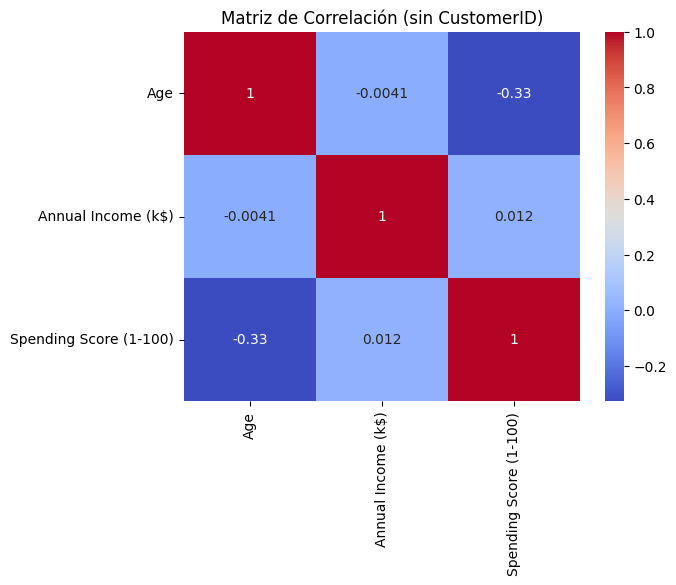

In [ ]:
# Seleccionamos las columnas numéricas para la matriz de correlación
num_columns = ['Age', 'Annual Income (k$)', 'Spending Score (1-100)']
corr_matrix = df[num_columns].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Matriz de Correlación (sin CustomerID)')
plt.show()

* **Age - Spending Score:** Hay una correlación negativa débil (-0.33), lo que indica que, en general, a mayor edad, el nivel de gasto tiende a ser menor.

* **Resto de correlaciones:** Las demás correlaciones son prácticamente nulas (cercanas a 0), lo que sugiere que no existe una relación significativa entre las variables restantes.

##2. Preprocesamiento de Datos

In [ ]:
# Creamos una copia del dataset para no afectar los datos originales
df_standard = df.copy()

In [ ]:
# Importamos StandardScaler para estandarizar las variables numéricas
from sklearn.preprocessing import StandardScaler

# Aplicamos StandardScaler sobre las variables numericas
scaler = StandardScaler()
df_standard[num_columns] = scaler.fit_transform(df[num_columns])

In [ ]:
# Codificamos la variable categórica y con el comando drop_first=True eliminamos una de las columnas generadas por el One-Hot Encoding para evitar la colinealidad
df_standard = pd.get_dummies(df_standard, columns=['Gender'], drop_first=True)

In [ ]:
# Eliminamos la columna CustomerID porque no aporta ningún valor de negocio más allá de identificar el cliente
df_standard = df_standard.drop(columns=['CustomerID'])

# Verificamos las columnas del dataset actualizado
print(df_standard.columns)

Index(['Age', 'Annual Income (k$)', 'Spending Score (1-100)', 'Gender_Male'], dtype='object')


##3. Aplicación de KMeans

In [ ]:
# Importamos el módulo de KMeans
from sklearn.cluster import KMeans

# Aplicamos KMeans en el dataset estandarizado con 4 clusters
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(df_standard)
y_kmeans = kmeans.predict(df_standard)

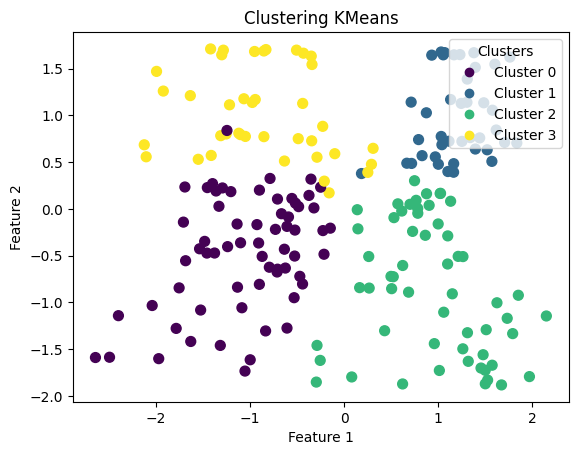

In [ ]:
# Importamos PCA y matplotlib
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Realizamos PCA para reducir a 2 dimensiones
pca = PCA(n_components=2)
X_pca = pca.fit_transform(df_standard)

# Etiquetas para los clusters
cluster_labels = [f'Cluster {i}' for i in range(max(y_kmeans) + 1)]

# Visualizamos los clusters
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_kmeans, cmap='viridis', s=50)
plt.title('Clustering KMeans')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')

# Agregamos la leyenda
handles, _ = scatter.legend_elements()
plt.legend(handles, cluster_labels, title="Clusters", loc="upper right")

plt.show()

**Separación de clusters:** Los clusters están bastante bien separados, aunque hay solapamiento en algunas zonas, especialmente entre los clusters 0 (morado) y 3 (amarillo).

**Distribución de los clusters:**

* **Cluster 0:** Muy concentrado en la zona inferior izquierda
* **Cluster 1:** Bien definido en la parte superior derecha.
* **Cluster 2:** Más disperso en la parte inferior derecha.
* **Cluster 3:** Bastante compacto en la parte superior izquierda.

**Solapamiento:** Hay algunas áreas donde los clusters se mezclan, lo que podría significar que ciertos datos tienen características similares entre grupos.

**Proyección en 2D:** El gráfico usa PCA para reducir dimensiones aunque puede perder algunos detalles de los datos originales.

**Conclusión:** Los clusters están bien definidos, pero de manera arbitraria no encontraremos la k óptima, por este motivo, vamos a realizar el método de Elbow.

##4. Método del Codo

###4.1. Elbow

In [ ]:
# Clusters a probar
max_clusters = 10

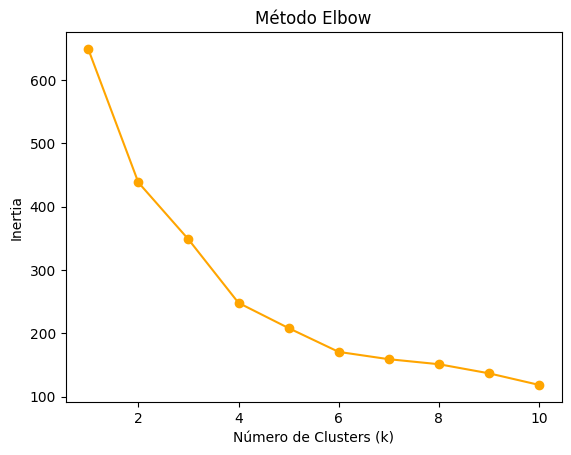

In [ ]:
# Calculamos el atributo inertia para el rango de 1 a 10 clusters
inertia_sklearn = []
for k in range(1, max_clusters + 1):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    kmeans.fit(df_standard)
    inertia_sklearn.append(kmeans.inertia_)

# Visualizamos la gráfica de Elbow
plt.plot(range(1, max_clusters + 1), inertia_sklearn, marker='o', color='orange')
plt.title('Método Elbow')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Inertia')
plt.show()

El gráfico del Método Elbow muestra cómo la **inercia disminuye a medida que se incrementa el número de clusters**.

* **Disminución de inercia:** Existe una caída pronunciada en la inercia entre 2 y 4 clusters, lo que significa una mejora significativa en la calidad del agrupamiento en este rango.

* **Punto de inflexión:** A partir de 4 clusters, la curva comienza a tener una menor pendiente, especialmente entre 4 y 6 clusters, por lo que agregar más clusters tiene un menor beneficio.

* **Elección de 6 clusters:** A partir de los 6 clusters hacia delante consideramos que la curva se empieza a aplanar lo suficiente para considerar que k=6 es una buena opción, ya que logra un balance entre la calidad de los clusters y la complejidad del modelo,.

De todas maneras, vamos a realizar el coeficiente de Silhouette para confirmar que k=6 es la k óptima.


###4.2. Silhouette

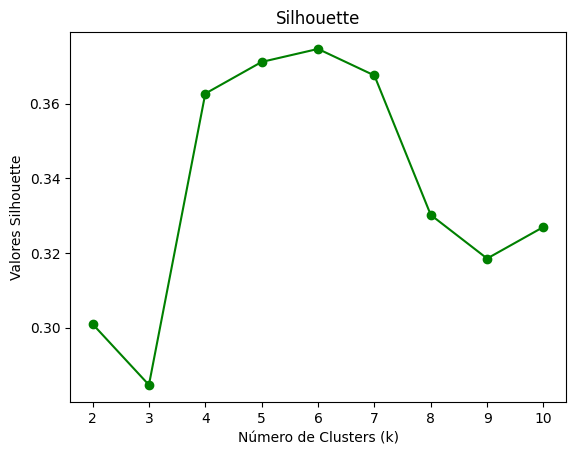

In [ ]:
#Importamos el coeficiente de Silhouette
from sklearn.metrics import silhouette_score


# Calculamos Silhouette para el rango de 2 a 10 clusters
silhouette_scores = []
k_values = range(2, max_clusters + 1)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    cluster_labels = kmeans.fit_predict(df_standard) # Obtenemos a qué cluster pertenece cada punto
    score = silhouette_score(df_standard, cluster_labels) # Calculamos la cohesión y separación
    silhouette_scores.append(score)

# Visualizamos
plt.plot(k_values, silhouette_scores, marker='o', color='green')
plt.title('Silhouette')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Valores Silhouette')
plt.show()

La k óptima se encuentra en el máximo global porque observando la fórmula del coeficiente de Silhouette vemos que cuanto mayor es la cohesion [a(i) pequeña] y cuanto mayor es la separación [b(i) grande] más cercano a 1 se encuentra el coeficiente.

Por tanto, podemos deducir que k=6 es la k óptima porque la distancia promedio del punto i a otros puntos de su propio cluster es la más pequeña posible y la distancia promedio del punto i a los puntos del cluster más cercano es la mayor posible.

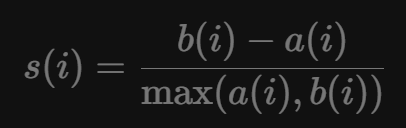

##5. Análisis de Clústeres

In [ ]:
# Aplicamos KMeans con 6 clusters
kmeans = KMeans(n_clusters=6, random_state=42)
kmeans.fit(df_standard)
y_kmeans = kmeans.predict(df_standard)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


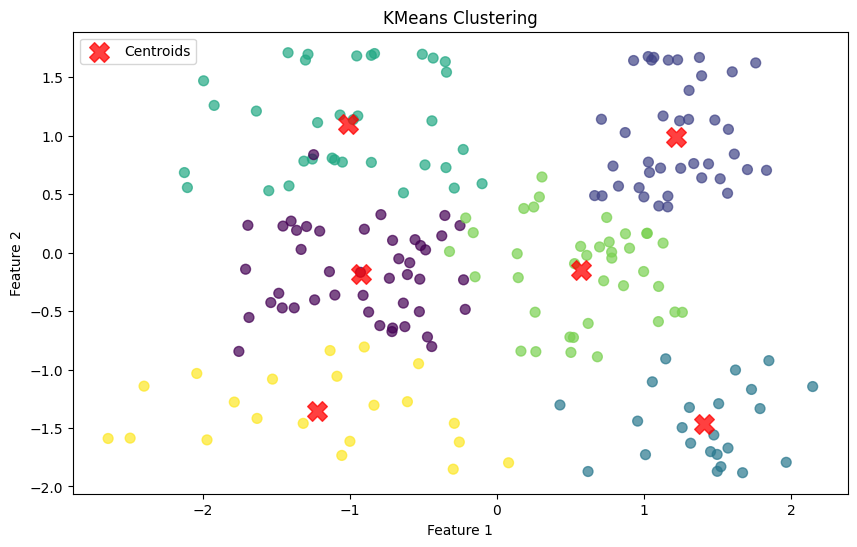

In [ ]:
# Transformamos los centroides a 2 dimensiones
centroids_pca = pca.transform(kmeans.cluster_centers_)

# Visualizamos los clusters con los centroides
plt.figure(figsize=(10, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_kmeans, cmap='viridis', s=50, alpha=0.7)
plt.scatter(centroids_pca[:, 0], centroids_pca[:, 1], c='red', s=200, alpha=0.75, marker='X', label='Centroids')
plt.title('KMeans Clustering')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.show()

**Separación de los clusters**: Con k=6, los clusters están razonablemente mejor definidos que en el caso de k=6, aunque en algunas áreas existe un leve solapamiento entre ellos:

* El cluster morado y el cluster verde claro tienen zonas cercanas en el centro del gráfico.

* El cluster azul de la esquina superior derecha y el cluster cian en la inferior derecha están bien diferenciados de los demás.

* Por último, el cluster verde oscuro de la zona superior izquierda y el cluster amarillo de la zona inferior izquierda muestran puntos más dispersos que los otros clusters. Esto nos lleva a deducir que las características de estos dos grupos es más diversa que los clusters donde parece ser más homogéneo.

Una vez finalizado el análisis descriptivo podemos pasar a hacer un análisis más específico sobre las características y patrones de cada cluster.






In [ ]:
# Añadimos al dataframe la columna Cluster
df['Cluster'] = y_kmeans

cluster_columns = ['Age', 'Annual Income (k$)', 'Spending Score (1-100)', 'Cluster']

# Calculamos las medias de las variables numéricas para cada clúster
cluster_mean = df[cluster_columns].groupby('Cluster').mean()

# Mostramos las medias
print(cluster_mean)



               Age  Annual Income (k$)  Spending Score (1-100)
Cluster                                                       
0        56.333333           54.266667               49.066667
1        32.692308           83.897436               82.128205
2        25.000000           25.260870               77.608696
3        41.264706           85.470588               16.764706
4        27.000000           56.657895               49.131579
5        45.523810           26.285714               19.380952


Realizando una media de los clusters para cada una de las variables podremos identificar los patrones ocultos que se han agrupado en los 6 clusters obtenidos mediante KMeans.

**Cluster 0:** Este grupo representa adultos mayores con ingresos medios y gasto promedio. Podrían ser los compradores más predecibles al tener un gasto moderado.

**Cluster 1:** Este clúster representa jóvenes/adultos con ingresos altos y un alto nivel de gasto. Es un grupo ideal para estrategias de fidelización o productos premium ya que, tienen un elevado poder adquisitivo y alta disposición a gastar.

**Cluster 2:** Este grupo esta conformado por jóvenes con ingresos bajos pero un nivel de gasto alto. Seguramente se trata de compradores impulsivos.

**Cluster 3:** Este clúster agrupa a adultos de ingresos altos pero con un nivel de gasto bajo. Seguramente estaríamos hablando de los clientes más ahorradores.

**Cluster 4:** Este grupo representa jóvenes con ingresos y nivel de gasto medio. Este grupo se asemeja mucho al primero que hemos comentado salvo que la edad media de este grupo es menor al anterior.

**Cluster 5:** Este último clúster representa adultos de edad media con ingresos y gasto bajos, probablemente enfrenten restricciones presupuestarias y priorizan gastos básicos.